# Basic pipeline

**Noam Gini 208375642  
Shai Fisher 315150342**

## Flight fares predictions using the following dataset: [Filght fares](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares)

### Imports of relevant packages

In [41]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

## Introducing the Flight fares dataset - Exploratory Data Analysis (EDA)

In [42]:
dtf = pd.read_csv("./data/data_airfare.csv")

In [43]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]

In [44]:
cols = ["Date_of_journey","Journey_day","Airline","Flight_code","Class",
        "Source","Departure","Total_stops","Arrival","Destination",
        "Duration_in_hours", "Days_left", "Fare"]
dtf = dtf[cols]

**Let's take a look at the data**

In [45]:
dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [46]:
dtf.describe()

,Duration_in_hours,Days_left,Fare
count,452088.000000,452088.000000,452088.000000
mean,12.349222,25.627902,22840.100890
std,7.431478,14.300846,20307.963002
min,0.750000,1.000000,1307.000000
25%,6.583300,13.000000,8762.750000
50%,11.333300,26.000000,13407.000000
75%,16.500000,38.000000,35587.000000
max,43.583300,50.000000,143019.000000


**Note:** The Fare of the flight tickets is in INR  
**1 USD = 82.78 INR**

**Examining the target feature - "Fare" Using Histogram, a KDE plot, and a Box plot**

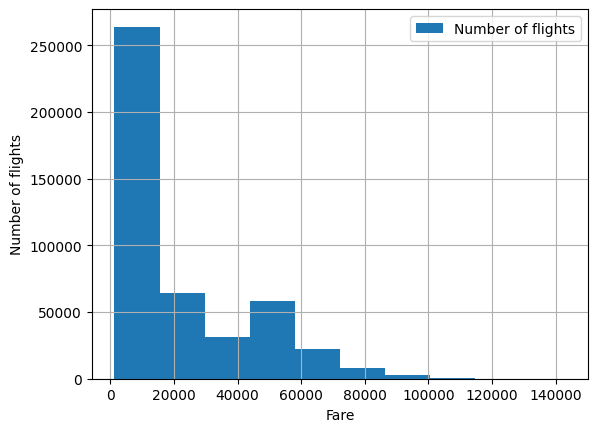

In [47]:
dtf.Fare.hist(label = 'Number of flights')

# Add labels to the x and y axes
plt.xlabel('Fare')
plt.ylabel('Number of flights')

# Add legend
plt.legend()

# Show the plot
plt.show()



Exploring the tickets fare:
From the description table above the histogram, we learn that the minimum ticket fare is 1,307 INR and maximum is 143,019 INR. There exists a difference in mean and median values as well.  
Now let's visualize the fare column using a kde plot and a box plot.

<Axes: xlabel='Fare', ylabel='Density'>

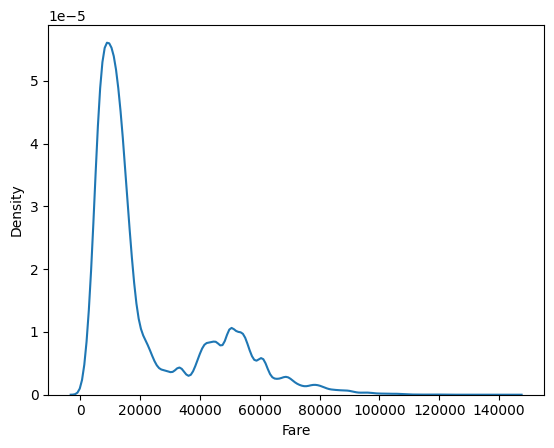

In [48]:
sns.kdeplot(dtf.Fare)

We can see that the data may contains outliers.

Let's examine the outliers

<Axes: xlabel='Fare'>

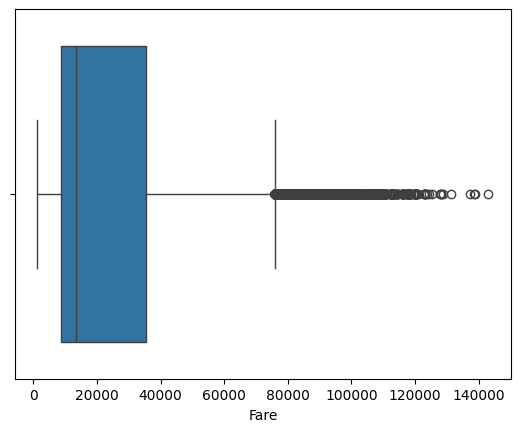

In [49]:
sns.boxplot(dtf.Fare, orient="h")

A Fare outlier is acceptable because there are different ticket classes - Economy, Premium Economy, Business and First class.
Even though the mean is around 20000, we can see that the median is approximately 14000.
In the KDE plot, we can see that the dispersion seems to be composed by two gaussian curves.
The first one - From 1,000 to 30,000 there is one peak, corresponding to the cheap tickets 
The second one - A peak from 40,000 to 80,000 corresponding to the expensive classes tickets.
We have decided not to remove the fare outliers for now.

## Cleaning and Preprocessing

We will make sure that there are no null values in our data

In [50]:
dtf.isnull().sum()

Date_of_journey      0
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Arrival              0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

There are no missing values in our dataset.

Now we will check for duplicates in our data

In [51]:
dtf.duplicated().sum()

6722

There are 6722 duplicated rows, So let's remove them.

In [52]:
dtf = dtf.drop_duplicates()

In [53]:
#check that the duplicates are gone
dtf.duplicated().sum()

0

We will change the 'Days_left' to a more indicitive name

In [54]:
# Change the column  from 'Days_left' to 'Advance_purchase_days' for clearity
dtf.rename(columns={'Days_left': 'Advance_days'}, inplace=True)

We will check the format and uniqueness of the 'Arrival' and 'Departure' values

In [55]:
dtf['Departure'].unique()

array(['After 6 PM', 'Before 6 AM', '12 PM - 6 PM', '6 AM - 12 PM'],
      dtype=object)

In [56]:
dtf['Arrival'].unique()

array(['After 6 PM', 'Before 6 AM', '6 AM - 12 PM', '12 PM - 6 PM'],
      dtype=object)

We will change the naming conventions for the 'Arrival' and 'Departure' fields

In [57]:
# Function to map departure time ranges to categories
def map_departure_time_range(departure_time):
    if 'Before 6 AM' in departure_time:
        return 'Early morning'
    elif '6 AM - 12 PM' in departure_time:
        return 'morning'
    elif '12 PM - 6 PM' in departure_time:
        return 'noon'
    else:
        return 'night'

# Apply the function to the columns
dtf['Departure'] = dtf['Departure'].apply(map_departure_time_range)
dtf['Arrival'] = dtf['Arrival'].apply(map_departure_time_range)

dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Advance_days,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,night,non-stop,night,Mumbai,2.1667,1,5955


We will examine the data related to dates

In [58]:
# Convert the "Date_of_journey" column to datetime format
dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])

# Extract the month from the dates
dtf['Month'] = dtf['Date_of_journey'].dt.month

# Group the flights by month and count the number of flights in each month
dtf.groupby('Month').size()

Month
1    140370
2    251603
3     53393
dtype: int64

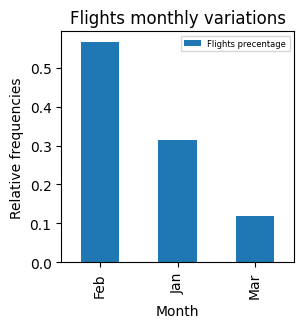

In [59]:
Month_ = pd.to_datetime(dtf.Date_of_journey.values).month
pd.Series(Month_.value_counts(normalize = True).values,index=["Feb","Jan","Mar"]).\
    plot(kind = 'bar', title="Flights monthly variations",  figsize=[3, 3], xlabel = "Month", ylabel = "Relative frequencies", label = "Flights precentage")
plt.legend(prop={'size': 6})
plt.show()

We can see that Feburary is a busy month in flights, this might be because February often marks the end of winter and the beginning of spring in many parts of India. This transition period might witness increased travel activities due to favorable weather conditions, leading to more flights.
 

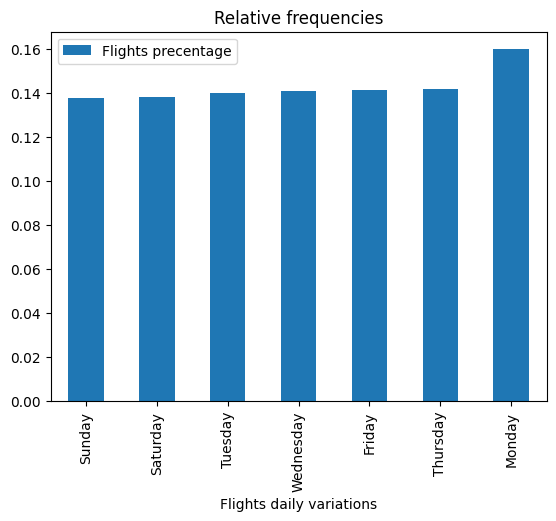

In [60]:
dtf.Journey_day.value_counts(normalize = True, ascending = True).plot(kind="bar",
 title = "Relative frequencies",xlabel = "Flights daily variations", label = "Flights precentage")
plt.legend()


We can see that the precentage of the flights is pretty similar for all the days, except Monday.
we would expect that there will be a significant difference between the number of flights during the weekend and the weekdays.

To ensure that our training and test sets accurately represent the daily variations observed in the dataset, where flights are evenly distributed across all seven weekdays, we will employ a stratified split based on this feature during the data partitioning process. This approach will help maintain the proportional representation of each weekday's frequencies in both the training and test sets.

### Visualization

Now we will take a look at the Histogram for each categorical attribute

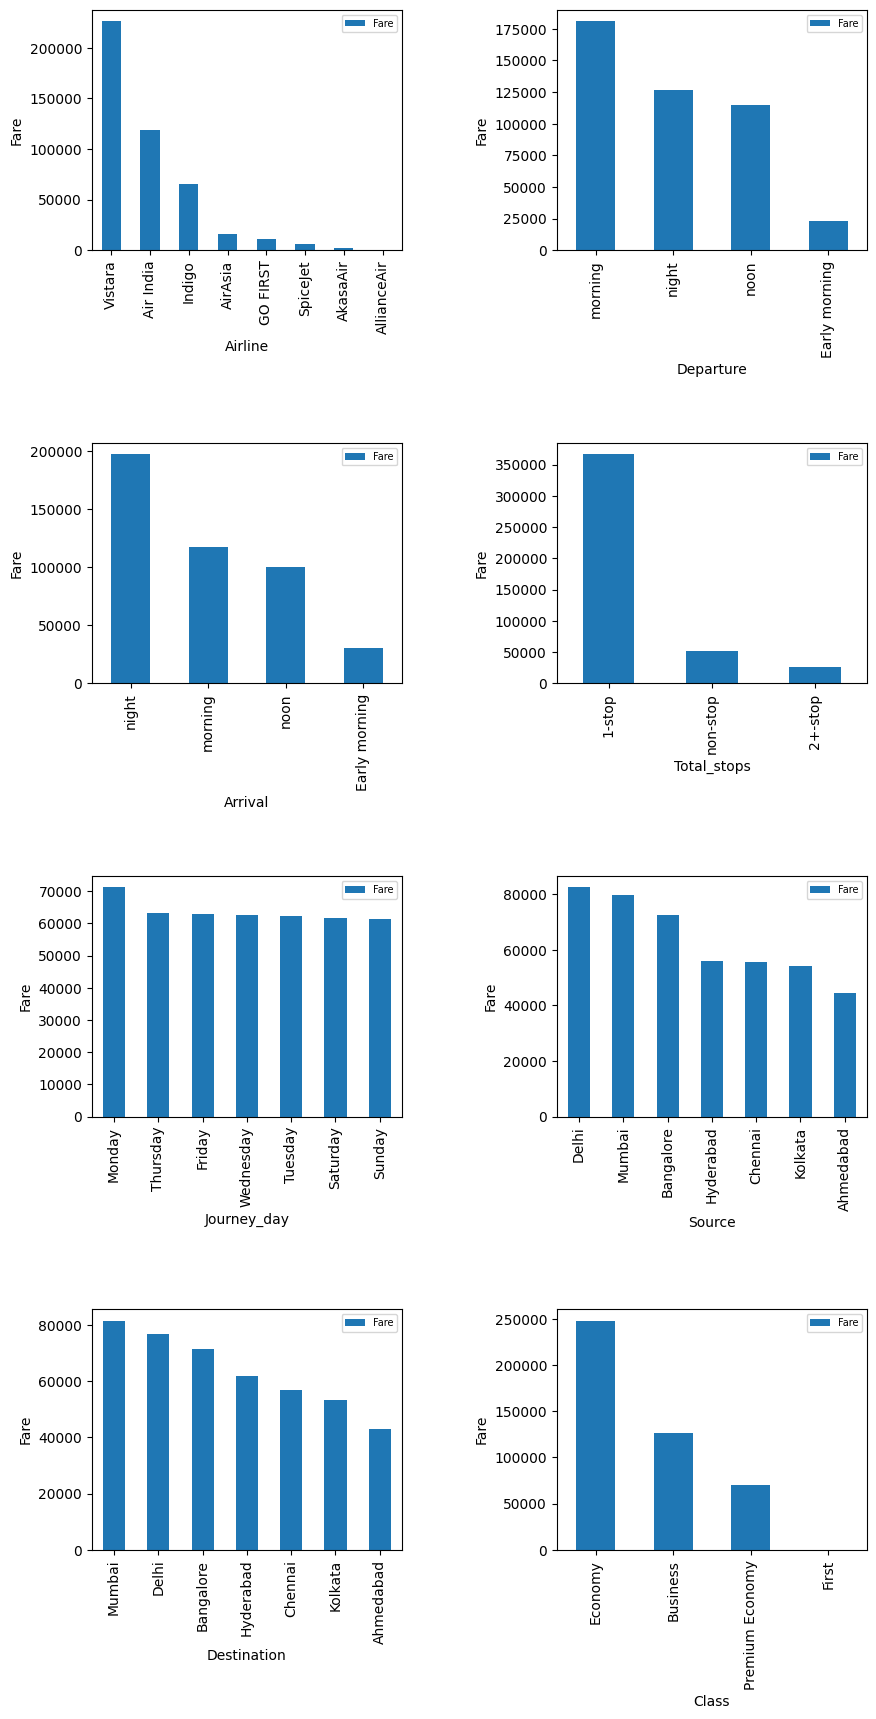

In [61]:

# Define the names of categorical columns to remove
columns_to_remove = ["Date_of_journey", "Flight_code"]

# Define the desired order of categorical columns
desired_order = ["Airline", "Departure", "Arrival", "Total_stops", "Journey_day", "Source", "Destination", "Class"]

# Filter categorical columns based on the condition and desired order
categorical_columns_filtered = [c for c in desired_order if c not in columns_to_remove]
                                
n = len(categorical_columns_filtered)
cols = 2
max_bars = 8

rows = (n // cols) + (1 if n % cols != 0 else 0)

#generate a figures grid
fig, axes = plt.subplots(rows,cols,figsize=(cols*5,rows*5))
fig.subplots_adjust(hspace=0.8, wspace=0.5)

for i,column in enumerate(categorical_columns_filtered):
    #calculate the current place on the grid
    r=int(i/cols)
    c=i%cols
    
    #create the "value counts" for the first <max_bars> categories
    u=min(dtf[column].nunique(),max_bars)
    vc = dtf[column].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c], xlabel = column, ylabel = "Fare", label="Fare")
    axes[r, c].legend(prop={'size':7})



And now for the numeric attributes

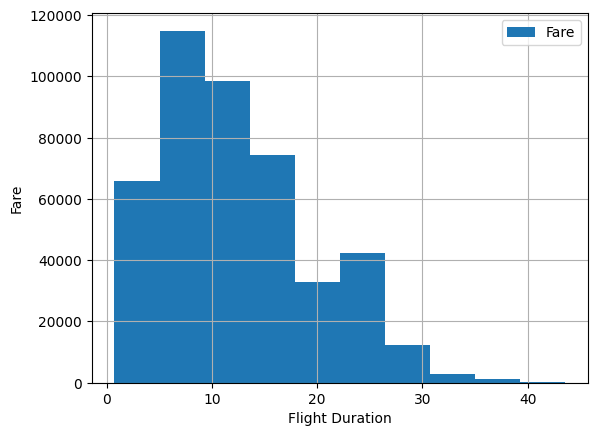

In [62]:
dtf.Duration_in_hours.hist(label = "Fare")

# Add labels to the x and y axes
plt.xlabel('Flight Duration')
plt.ylabel('Fare')
plt.legend()

# Show the plot
plt.show()

We can see that most expensive flights are around 10 hours.

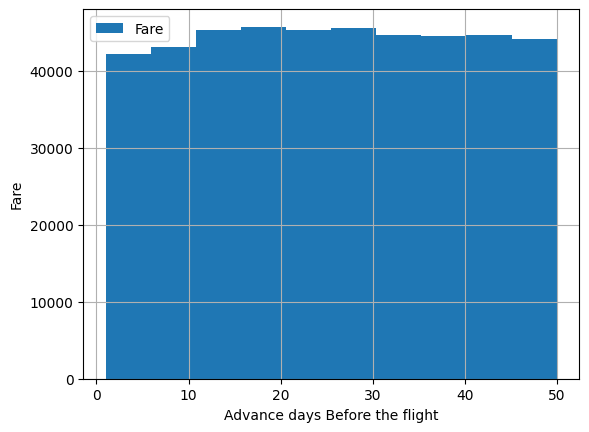

In [63]:
dtf.Advance_days.hist(label = "Fare")

# Add labels to the x and y axes
plt.xlabel('Advance days Before the flight')
plt.ylabel('Fare')
plt.legend()

# Show the plot
plt.show()

We can see that there is no significant meaning for booking the flight in advance.

We will examine the destinations, analyzing the flight frequencies for each part of the day

In [64]:
data = dtf.groupby("Destination")["Arrival"].value_counts()
data.head(28)

Destination  Arrival      
Ahmedabad    night            20133
             morning          12197
             noon              9773
             Early morning      927
Bangalore    night            32875
             morning          21241
             noon             12845
             Early morning     4642
Chennai      night            26399
             morning          16590
             noon             10751
             Early morning     3320
Delhi        night            29925
             noon             21786
             morning          16890
             Early morning     8157
Hyderabad    night            24154
             noon             17376
             morning          15319
             Early morning     4926
Kolkata      night            26829
             morning          16127
             noon              8356
             Early morning     2153
Mumbai       night            36657
             noon             19435
             morning          19301
 

Now, let's examine a Violin plot showcasing the fare distribution for each class

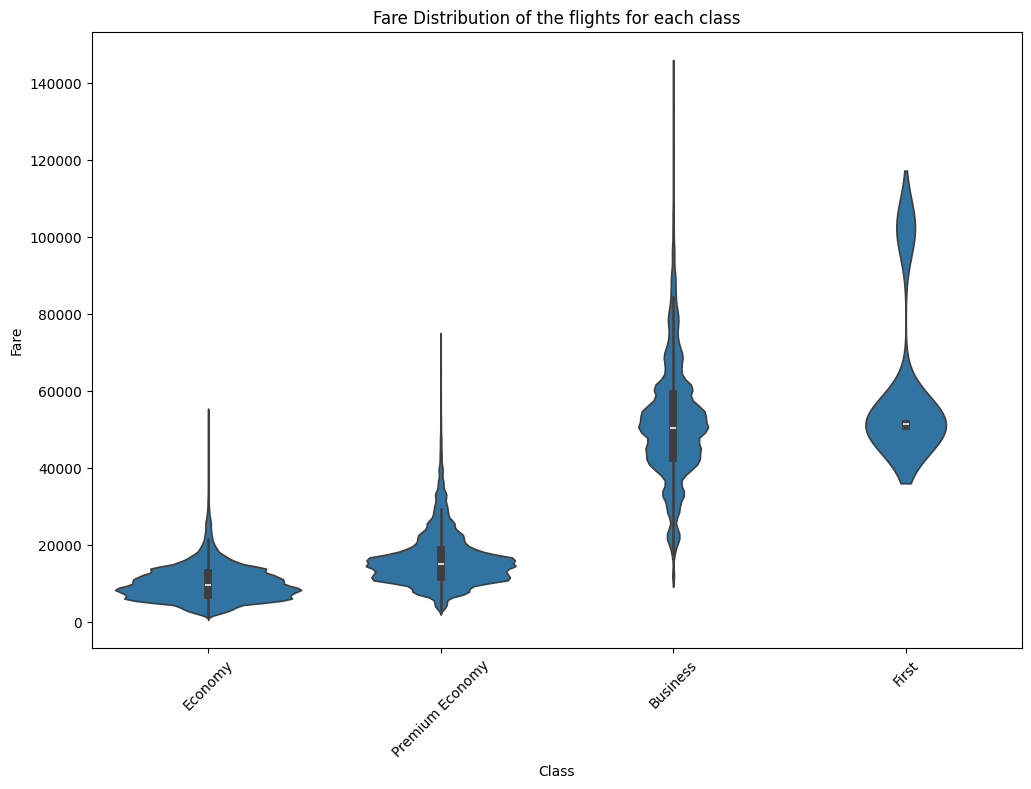

In [65]:
# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Class', y='Fare', data=dtf)
plt.title('Fare Distribution of the flights for each class')
plt.xlabel('Class')
plt.ylabel('Fare')
plt.xticks(rotation=45)
plt.show()

Using the Violin plot, we can gain insights into the distribution of flight fares across different class types:
- Economy class has an average fare of 10,000 INR, with the majority of listings falling between 5,000 INR and 15,000 INR.
- Premium Economy class has an average fare of 15,000 INR, with the majority of listings ranging from 10,000 INR to 20,000 INR.
- Business class has an average fare of 50,000 INR, with most listings falling between 40,000 INR and 60,000 INR.
- First class has an average fare of 50,000 INR, with the majority of listings between 45,000 INR and 55,000 INR. Additionally, there is another peak around 100,000 INR.
  
It's evident that Business and First class tickets are more expensive compared to Economy and Premium Economy, as expected.

### Examining Correlations to the target feature

<Axes: >

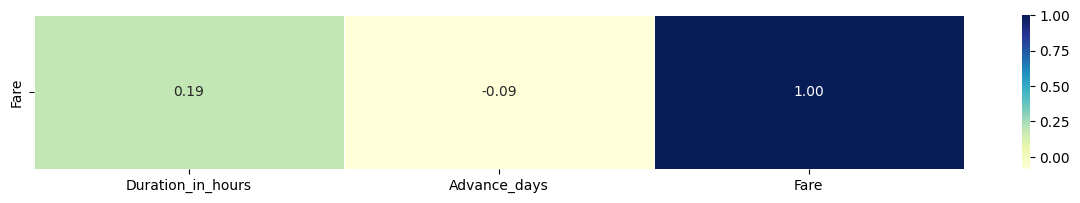

In [66]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
numeric_columns = dtf[numeric_columns]
dtf_corr = numeric_columns.corr(method="pearson").loc[["Fare"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

Weak correlations were observed between fare and flight duration (0.19) as well as advance ticket purchase days (-0.09), suggesting slight trends but not conclusive associations.

In [67]:
# Create a copy of the original DataFrame to preserve original attributes
original_dtf = dtf.copy()
print(original_dtf)

       Date_of_journey Journey_day    Airline Flight_code     Class  \
0           2023-01-16      Monday   SpiceJet     SG-8169   Economy   
1           2023-01-16      Monday     Indigo     6E-2519   Economy   
2           2023-01-16      Monday   GO FIRST      G8-354   Economy   
3           2023-01-16      Monday   SpiceJet     SG-8709   Economy   
4           2023-01-16      Monday  Air India      AI-805   Economy   
...                ...         ...        ...         ...       ...   
452081      2023-03-06      Monday    Vistara      UK-918  Business   
452082      2023-03-06      Monday    Vistara      UK-946  Business   
452083      2023-03-06      Monday    Vistara      UK-926  Business   
452084      2023-03-06      Monday    Vistara      UK-918  Business   
452086      2023-03-06      Monday    Vistara      UK-946  Business   

           Source      Departure Total_stops        Arrival Destination  \
0           Delhi          night    non-stop          night      Mumbai 

### Converting categorial attributes to numeric values

In [28]:
dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])  # Convert to datetime if not already

# Find the minimum date in the column as a reference point
min_date = dtf['Date_of_journey'].min()

# Convert the dates to numeric values representing elapsed time in days
dtf['Date_of_journey_numeric'] = (dtf['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days

In [29]:
day_mapping = {
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7
}

# Map the days of the week to numeric values
dtf['Journey_day_numeric'] = dtf['Journey_day'].map(day_mapping)


In [30]:
class_mapping = {
    'Economy': 1,
    'Premium Economy': 2,
    'Business': 3,
    'First': 4
}

# Map the class to numeric values
dtf['Class'] = dtf['Class'].map(class_mapping)

In [31]:
stop_mapping = {
    'non-stop': 0,
    '1-stop': 1,
    '2+-stop': 2
}

# Map the total stops to numeric values
dtf['Total_stops'] = dtf['Total_stops'].map(stop_mapping)

**Date_of_journey ----> Date_of_journey_numeric**  
Our data is between 16/01/2023 and 06/03/2023 therefore we converted the dates in the following format:  
16/01/2023 ----> 0  
17/01/2023 ----> 1  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
06/03/2023 ----> 49  

**Journey_day ----> Date_of_journey_numeric**  
'Sunday' ----> 1  
'Monday' ----> 2  
'Tuesday' ----> 3  
'Wednesday' ----> 4  
'Thursday' ----> 5  
'Friday' ----> 6  
'Saturday' ----> 7  


Converting all the other categorial attributes by a LabelEncoder function

In [32]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
label_encoder = LabelEncoder()
for col in ['Airline', 'Flight_code', 'Source', 'Departure', 'Arrival', 'Destination']:
    dtf[col] = label_encoder.fit_transform(dtf[col])

# Drop original datetime columns
dtf.drop(columns=['Date_of_journey', 'Journey_day'], inplace=True)

print(dtf)


        Airline  Flight_code  Class  Source  Departure  Total_stops  Arrival  \
0             6         1209      1       3          2            0        2   
1             5          164      1       3          2            0        0   
2             4          942      1       3          2            0        0   
3             6         1224      1       3          2            0        2   
4             0          852      1       3          2            0        2   
...         ...          ...    ...     ...        ...          ...      ...   
452081        8         1358      3       0          0            1        3   
452082        8         1374      3       0          1            1        2   
452083        8         1360      3       0          1            1        2   
452084        8         1358      3       0          0            1        3   
452086        8         1374      3       0          1            1        2   

        Destination  Duration_in_hours 

<Axes: >

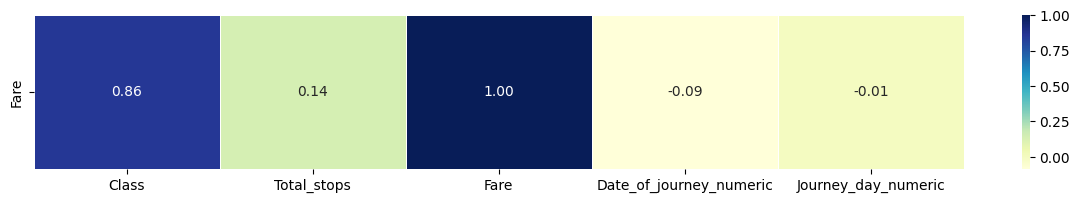

In [33]:
columns_checked = ["Duration_in_hours","Advance_days"]
columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
columns = [c for c in columns if c not in columns_checked]
columns = dtf[columns]
dtf_corr = columns.corr(method="pearson").loc[["Fare"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

We didn't observe any significant correlation between the flight Fare and the other attributes.

## Baseline Model

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

In [35]:
# We will split the dataset into features and target variables. The target variable is the fare, and all the others are the features.
# Our predictors
X = dtf.drop(columns = 'Fare')

# Our outcome variable
y = dtf.Fare

We will split the data to test and training sets with stratified method based on the daily variation of flights with shaffle before split.

In [36]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=dtf["Journey_day_numeric"], random_state=42, shuffle = True)

In [37]:
# Train XGBoost as a baseline model for our pipeline
baseline_model = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
y_pred = baseline_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.948909138636579


A R-squared (R²) score of 0.9497 indicates that approximately 94.97% of the variance in the dependent variable (target variable) is explained by the independent variables (predictors) in your regression model.

In [39]:
print("Mean Absolute Perc Error:","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean Absolute Error:", "{:,.0f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

## residuals
residuals = y_test - y_pred
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error].index[0]
#max_true, max_pred = y_test.loc[max_idx], prediction[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error: 0.141
Mean Absolute Error: 2,697
Root Mean Squared Error: 4,608
Max Error: 49,397


We now plot the true values against the predicted values.

KeyboardInterrupt: 

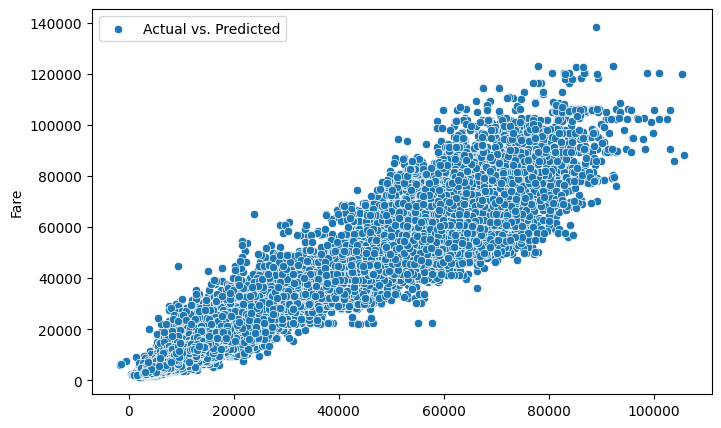

In [40]:
# print the predicted fares regression plot
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred,y=y_test,ax=ax, label='Actual vs. Predicted')
sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='red', label='Ideal Fit')
ax.set_xlabel('Predicted Fares')
ax.set_ylabel('Actual Fares')
ax.legend()
plt.show()

In [ ]:
residuals.hist(label = 'Number of flights')
# Add labels to the x and y axes
plt.xlabel('Residuals')
plt.ylabel('Number of flights')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot for absolute residuals
sns.scatterplot(x=y_pred, y=residuals, ax=ax[0], label='Absolute Residuals')
sns.lineplot(x=y_pred, y=0, ax=ax[0], color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].legend()  # Add legend
ax[0].set_xlabel('Predicted Fares')  # Add x-axis label

# Scatter plot for percentage residuals
sns.scatterplot(x=y_pred, y=residuals/y_test, ax=ax[1], label='Percentage Residuals')
sns.lineplot(x=y_pred, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].legend()  # Add legend
ax[1].set_xlabel('Predicted Fares')  # Add x-axis label

plt.show()

We can see that we have some big mistakes and some small mistakes

In [ ]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

How many time did our model achieve low estimation error (error less than 5%)?

In [ ]:
len(rel_res[rel_res<0.05])/len(rel_res)

How many time did our model achieve low estimation error (error more than 20%)?:

In [ ]:
len(rel_res[rel_res>0.2])/len(rel_res)

## Results

The baseline model has a Mean Absolute Error of 2,663 and an R2 score of ~0.9497, which looks almost like a perfect fit for our model.  
The regression plot shows that the predicted fares are close to the actual fares, and the residuals distribution plot shows that the residuals are normally distributed around 0.
We can see that in the residuals histogram most of the residuals are around 0, which means the prediction is pretty accurate.
we can see that there are more low estimators than high.

In [ ]:
 ## ------------------------------------ PART 3  ------------------------------------

Now, we would like to analyze the predictions using the SHAP library, a tool commonly used for interpreting machine learning models. Therefore, we'll sample the top overpredicted and underpredicted instances. By doing so, we aim to discern patterns and underlying factors contributing to these predicted outliers.

In [ ]:

# Calculate the difference between predicted and actual fares
fare_difference = y_pred - y_test

# Sorting the fare differences
sorted_fare_difference = fare_difference.sort_values(ascending=False)

# Get the indices of top 1000 over-predicted and under-predicted samples
top_1000_over_predicted_indices = sorted_fare_difference.index[:1000]
top_1000_under_predicted_indices = sorted_fare_difference.index[-1000:]

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples = dtf.loc[top_1000_over_predicted_indices].drop(columns=['Fare'])
top_1000_under_predicted_samples = dtf.loc[top_1000_under_predicted_indices].drop(columns=['Fare'])


# Print the top 1000 over-predicted and under-predicted samples
print("Top 1000 Over-predicted Samples:")
print(top_1000_over_predicted_samples)
print("\nTop 1000 Under-predicted Samples:")
print(top_1000_under_predicted_samples)

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples_original = original_dtf.loc[top_1000_over_predicted_indices]
top_1000_under_predicted_samples_original = original_dtf.loc[top_1000_under_predicted_indices]

# Print the top 1000 over-predicted and under-predicted samples
print("Top 1000 Over-predicted Samples original:")
print(top_1000_over_predicted_samples_original)
print("\nTop 1000 Under-predicted Samples original:")
print(top_1000_under_predicted_samples_original)

In [ ]:
# # Count the occurrences of each source in the top 1000 over-predicted samples
# over_pred_source_counts = top_1000_over_predicted_samples['Advance_days'].value_counts()
# under_pred_source_counts = top_1000_under_predicted_samples['Advance_days'].value_counts()

# print("Counts of sources in the top 1000 over-predicted samples:")
# print(over_pred_source_counts)

# print("Counts of sources in the top 1000 under-predicted samples:")
# print(under_pred_source_counts)


We are curious to verify if the gap in the 'Source' values, particularly for Delhi, are consistent with the original data.

In [ ]:
# Count the occurrences of each source in the entire dataset 
source_counts = X_test['Source'].value_counts()

total_samples = X_test.shape[0]
source_percentages = (source_counts / total_samples) * 100

print("Sources, their counts, and percentages:")
for source, count in source_counts.items():
    percentage = source_percentages.get(source, 0)
    print(f"{source}: {count} ({percentage:.2f}%)")

We observe that there isn't a significant gap among the source values, particularly for Delhi, Mumbai, and Bangalore, which appear more frequently.
We will keep that in mind.

### SHAP analysis

In [ ]:
import shap

explainer = shap.TreeExplainer(baseline_model)

# Calculate SHAP values for top over-predicted and under-predicted samples
shap_values_over_predicted = explainer(top_1000_over_predicted_samples)
shap_values_under_predicted = explainer(top_1000_under_predicted_samples)

### Visualize SHAP summary plot for top over-predicted samples

In [ ]:
shap.summary_plot(shap_values_over_predicted, features=top_1000_over_predicted_samples, title="SHAP Summary Plot - Top Over-predicted Samples")

### Visualize SHAP summary plot for top under-predicted samples

In [ ]:
shap.summary_plot(shap_values_under_predicted, features=top_1000_under_predicted_samples, title="SHAP Summary Plot - Top Under-predicted Samples")

Both plots illustrate the effect of the different features on predictions. Samples further away from the zero line indicate a stronger negative or positive effect on price predictions. For instance, in the 'class' feature, "low" blue dots (representing economy class) are associated with lower predicted prices than actual prices, while "high" red dots (representing first class) are associated with higher predicted prices than actual prices.
We can also see that in the 'Advance_days' feature, we observe an inverse relationship: higher values (indicating booking the flight well in advance) correspond to lower predicted prices, and conversely, lower values correspond to higher predicted prices.

In [ ]:
shap.plots.bar(shap_values_over_predicted)

Note: We ran the bar plot also for the underpredicted shap values and got a similar result so we present just the overpredicted plot. 

### SHAP Conclusions

Note: We conducted SHAP analysis on the entire dataset as well, although we didn't include it, in order to reduce  the number of plots.
However, we'll utilize insights from this analysis to draw conclusions.
To summarize briefly, the 'class' feature has the most significant influence on the predictions. Additionally, 'duration_in_hours' and 'advance_days' have a similar effects on the predictions, (smaller gaps between them then the ones shown on the above bar plot).
Moreover, there's a difference in the influence of the 'source' feature, where in the above plot a larger effect is shown.

After running SHAP on the overpredicted and underpredicted instances, we got to a few interesting conclusions:
- We can see that the most influence on the over/under predicted instances is the Class feature, but we also noticed that it has the most influence on the predictions of the entire data, so it fits our expectations.
- In the source feature we saw a small difference between the influence of it on the entire data predictions, where in the top 1000 over/under predicted instances we saw it had a larger effect, and it suits our suspicions regarding the amount of occurences of delhi in our 1000 over/under predicted instances
- In the duration_in_hours feature has influence on the over/under predicted instances. We can see that "low" blue dots (representing shorter flight duration) are associated with lower predicted prices than actual prices, as expected.

In [ ]:
# # Define bins for advanced_days
# bins = [0, 14, 28, float('inf')]
# labels = [0, 1, 2]
# data= dtf.copy()
# # Bin advanced_days
# data['Advance_days_bin'] = pd.cut(data['Advance_days'], bins=bins, labels=False, right=True)
# data= data.drop(columns=['Advance_days'])
# # Convert the bin labels to integers
# data['Advance_days_bin'] = data['Advance_days_bin'].astype(int)
# print(data)


In [ ]:
# # Extract the corresponding samples from the dataset
# top_1000_over_predicted_samples = data.loc[top_1000_over_predicted_indices].drop(columns=['Fare'])
# top_1000_under_predicted_samples = data.loc[top_1000_under_predicted_indices].drop(columns=['Fare'])

# # Count the occurrences of each source in the top 1000 over-predicted samples
# over_pred_source_counts = top_1000_over_predicted_samples['Advance_days_bin'].value_counts()
# under_pred_source_counts = top_1000_under_predicted_samples['Advance_days_bin'].value_counts()

# print("Counts of sources in the top 1000 over-predicted samples:")
# print(over_pred_source_counts)

# print("Counts of sources in the top 1000 under-predicted samples:")
# print(under_pred_source_counts)

In [ ]:
# Split the dataset into training and testing sets
# X_test['Advance_days']= data['Advance_days_bin']
# X_train['Advance_days']= data['Advance_days_bin']
# print(X_test)

In [ ]:
# Count the occurrences of each source in the top 1000 over-predicted samples
over_pred_source_counts = top_1000_over_predicted_samples['Class'].value_counts()
under_pred_source_counts = top_1000_under_predicted_samples['Class'].value_counts()

print("Counts of sources in the top 1000 over-predicted samples:")
print(over_pred_source_counts)

print("Counts of sources in the top 1000 under-predicted samples:")
print(under_pred_source_counts)

In [ ]:
# # Train XGBoost as a baseline model for our pipeline
# baseline_model_new = xgb.XGBRegressor(objective="reg:squarederror")
# baseline_model_new.fit(X_train, y_train)

In [ ]:
# y_pred = baseline_model_new.predict(X_test)
# print("R2 Score:", r2_score(y_test, y_pred))

In [ ]:
# # print the predicted fares regression plot
# fig, ax = plt.subplots(figsize=(8,5))
# sns.scatterplot(x=y_pred,y=y_test,ax=ax, label='Actual vs. Predicted')
# sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='red', label='Ideal Fit')
# ax.set_xlabel('Predicted Fares')
# ax.set_ylabel('Actual Fares')
# ax.legend()
# plt.show()

In [ ]:
# Drop the top 1000 over-predicted and under-predicted instances from the data
# dtf = dtf.drop(index=top_1000_over_predicted_indices)
# dft = dtf.drop(index=top_1000_under_predicted_indices)
# Get information for a specific index
# specific_index_info = dtf.iloc[1038]
# print(specific_index_info)
# specific_index_info1 = dtf.iloc[60406]
# print(specific_index_info1)

In [ ]:
# # Split the dataset into training and testing sets
# X = dtf.drop(columns = 'Fare')

# # Our outcome variable
# y = dtf.Fare
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=dtf["Journey_day_numeric"], random_state=42, shuffle = True)

In [ ]:
# # Train XGBoost as a baseline model for our pipeline
# print(dtf)
# baseline_model_rm_outliers = xgb.XGBRegressor(objective="reg:squarederror")
# baseline_model_rm_outliers.fit(X_train, y_train)

In [ ]:
# y_pred = baseline_model_new.predict(X_test)
# print("R2 Score:", r2_score(y_test, y_pred))

In [ ]:
#y_log = np.log(y)
y_log = np.cbrt(y)
#y_log = np.log10(y)
X_train, X_test, y_train, y_test = train_test_split(X,y_log, test_size=0.2, stratify=dtf["Journey_day_numeric"], random_state=42, shuffle = True)

# Define punishment weights based on class values
class_punishment = {1: 2, 2: 1, 3: 2}  # Punish class 3 more heavily

# Create custom weights for each sample based on its class
sample_weights_train = np.array([class_punishment.get(c, 1) for c in X_train["Class"]])
sample_weights_test = np.array([class_punishment.get(c, 1) for c in X_test["Class"]])

# Define the XGBoost regressor
baseline_model_log_fare_weighted = xgb.XGBRegressor(objective="reg:squarederror")

# Train the model with custom sample weights
baseline_model_log_fare_weighted.fit(X_train, y_train, sample_weight=sample_weights_train)

# The best hyperparameters
best_params = {'learning_rate': 0.2, 'max_depth': 9, 'reg_lambda': 0}

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

In [ ]:
y_pred = best_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

In [ ]:
print("Mean Absolute Perc Error:","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred)))

In [ ]:
# Calculate the difference between predicted and actual fares
fare_difference = y_pred - y_test

# Sorting the fare differences
sorted_fare_difference = fare_difference.sort_values(ascending=False)

# Get the indices of top 1000 over-predicted and under-predicted samples
top_1000_over_predicted_indices = sorted_fare_difference.index[:1000]
top_1000_under_predicted_indices = sorted_fare_difference.index[-1000:]

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples = dtf.loc[top_1000_over_predicted_indices].drop(columns=['Fare'])
top_1000_under_predicted_samples = dtf.loc[top_1000_under_predicted_indices].drop(columns=['Fare'])


# Print the top 1000 over-predicted and under-predicted samples
print("Top 1000 Over-predicted Samples:")
print(top_1000_over_predicted_samples)
print("\nTop 1000 Under-predicted Samples:")
print(top_1000_under_predicted_samples)

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples_original = original_dtf.loc[top_1000_over_predicted_indices]
top_1000_under_predicted_samples_original = original_dtf.loc[top_1000_under_predicted_indices]

# Print the top 1000 over-predicted and under-predicted samples
print("Top 1000 Over-predicted Samples original:")
print(top_1000_over_predicted_samples_original)
print("\nTop 1000 Under-predicted Samples original:")
print(top_1000_under_predicted_samples_original)

In [ ]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for top over-predicted and under-predicted samples
shap_values_over_predicted = explainer(top_1000_over_predicted_samples)
shap_values_under_predicted = explainer(top_1000_under_predicted_samples)

In [ ]:
shap.summary_plot(shap_values_over_predicted, features=top_1000_over_predicted_samples, title="SHAP Summary Plot - Top Over-predicted Samples")

In [ ]:
shap.plots.bar(shap_values_over_predicted)

In [ ]:
# Count the occurrences of each source in the top 1000 over-predicted samples
over_pred_source_counts = top_1000_over_predicted_samples['Class'].value_counts()
under_pred_source_counts = top_1000_under_predicted_samples['Class'].value_counts()

print("Counts of sources in the top 1000 over-predicted samples:")
print(over_pred_source_counts)

print("Counts of sources in the top 1000 under-predicted samples:")
print(under_pred_source_counts)

In [ ]:
#maybe add embadding with vector
print(dtf['Duration_in_hours'])
print(max(dtf['Duration_in_hours']))

In [69]:
import tensorflow as tf
import keras
from sklearn import metrics, preprocessing
from tensorflow.keras import layers, utils, callbacks, optimizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import StratifiedKFold

In [ ]:
# features = [f for f in original_dtf.columns if f not in ['Duration_in_hours','Days_left','Advance_days','Date_of_journey', 'Fare']]
# print(features)

In [ ]:
# original_dtf_copy = original_dtf.copy()

# # Convert the dates to numeric values representing elapsed time in days
# original_dtf_copy['Date_of_journey_numeric'] = (original_dtf_copy['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days
# original_dtf_copy=original_dtf_copy.drop(columns=['Date_of_journey'])

# for f in features:
#     lbl_enc= preprocessing.LabelEncoder()
#     original_dtf_copy.loc[:,f]=lbl_enc.fit_transform(original_dtf_copy[f].astype(str).fillna("-1").values)

In [ ]:
# X = original_dtf_copy.drop(columns = 'Fare')
# # Our outcome variable
# y = original_dtf_copy.Fare

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=original_dtf_copy["Journey_day"], random_state=42, shuffle = True)

In [ ]:
# # train = original_dtf_copy[original_dtf_copy.iloc[:, -1] != -1].reset_index(drop=True)
# # test = original_dtf_copy[original_dtf_copy.iloc[:, -1]].reset_index(drop=True)
# # test_data = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]
# # print(test.shape)
# X_train, X_test, y_train, y_test = train_test_split(train[features], train['Fare'], test_size=0.2, stratify=train["Journey_day"], random_state=42, shuffle=True)
# print(X_train.shape[0])

In [ ]:
# def create_model(data, categorical_cols):    
#     inputs = []
#     outputs = []
#     for c in categorical_cols:
#         num_unique_values = int(data[c].nunique())
#         embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
#         inp = layers.Input(shape=(1,))
#         out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
#         out = layers.SpatialDropout1D(0.3)(out)
#         out = layers.Reshape(target_shape=(embed_dim, ))(out)
#         inputs.append(inp)
#         outputs.append(out)
    
#     x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Dense(300, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Dense(300, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.BatchNormalization()(x)
    
#     y = layers.Dense(2, activation="softmax")(x)

#     model = Model(inputs=inputs, outputs=y)
#     return model

In [ ]:
# oof_preds = np.zeros(X_train.shape[0])
# test_preds = np.zeros(X_test.shape[0])

# skf = StratifiedKFold(n_splits=50)
# for train_index, test_index in skf.split(X_train, X_train.target.values):
#     X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
#     X_train = X_train.reset_index(drop=True)
#     X_test = X_test.reset_index(drop=True)
#     y_train, y_test = X_train.iloc[:, -1], X_test.iloc[:, -1]
#     model = create_model(X_train,features)
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
#     X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
#     X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    
#     es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
#                                  verbose=1, mode='max', baseline=None, restore_best_weights=True)

#     rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
#                                       patience=3, min_lr=1e-6, mode='max', verbose=1)
    
#     model.fit(X_train,
#               utils.to_categorical(y_train),
#               validation_data=(X_test, utils.to_categorical(y_test)),
#               verbose=1,
#               batch_size=1024,
#               callbacks=[es, rlr],
#               epochs=100
#              )
#     valid_fold_preds = model.predict(X_test)[:, 1]
#     test_fold_preds = model.predict(test_data)[:, 1]
#     oof_preds[test_index] = valid_fold_preds.ravel()
#     test_preds += test_fold_preds.ravel()
#     print(metrics.roc_auc_score(y_test, valid_fold_preds))
#     K.clear_session()

In [ ]:
# model = create_model(X_train,features)
# model.summary()

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer='adam')
# X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
# X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]

In [ ]:
# model.fit([X_train.loc[:, f].values for f in features], utils.to_categorical(y_train))

# new try!

In [70]:
# # Data processing
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Embedding, Reshape
from tensorflow.keras.layers import Concatenate

# # Train test split
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import RandomForestRegressor

# Visualization
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)}) # Set figure size
import matplotlib.pyplot as plt

# Visualize neural network model structure
from keras.utils import plot_model
from IPython.display import Image

# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping

In [ ]:
original_dtf_copy = original_dtf.copy()
original_dtf_copy = original_dtf_copy.drop(['Date_of_journey','Journey_day','Airline','Flight_code','Class','Source','Departure','Total_stops'], axis = 1)
original_dtf_copy.head()

In [ ]:
X = original_dtf_copy.drop(['Fare'], axis = 1)
y = original_dtf_copy['Fare']

In [ ]:
cols_to_keep = ['Destination', 
                'Class',
                'Source','Airline']


In [ ]:

# Features
X = original_dtf_copy.iloc[:, 1:].copy().drop('Fare', axis=1)

# Target
y = original_dtf_copy['Fare']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.columns)

# Check the number of records in training and testing dataset.
print(f'The training dataset has {X_train.shape[0]} records and {X_train.shape[1]} columns.')
print(f'The testing dataset has {len(X_test)} records.')

In [ ]:
# Input list for the training data
input_list_train = []

# Input list for the testing data
input_list_test = []

# Categorical encoder is in dictionary format
cat_encoder = {}

# Unique values for the categorical variable
unique_cat = np.unique(X_train['Destination'])

# Print out the number of unique values in the categorical variable
print(f'There are {len(unique_cat)} unique Destination in the training dataset.\n')

# Encode the categorical variable
for i in range(len(unique_cat)):
  cat_encoder[unique_cat[i]] = i

# Take a look at the encoder
cat_encoder

In [ ]:
# Append the values to the input list
input_list_train.append(X_train['Destination'].map(cat_encoder).values)
input_list_test.append(X_test['Destination'].map(cat_encoder).values)

# Take a look at the data
print('input_list_train:', input_list_train)
print('input_list_test:', input_list_test)

In [ ]:
# Number of unique values in the categorical col
n_unique_cat = len(unique_cat)

# Input dimension of the categorical variable
input_cat = Input(shape=(1,))

# Output dimension of the categorical entity embedding
cat_emb_dim = 5

# Embedding layer
emb_cat = Embedding(input_dim=n_unique_cat, output_dim=cat_emb_dim, name="embedding_cat")(input_cat)
# Check the output shape
print(emb_cat)

# Reshape
emb_cat = Reshape(target_shape=(cat_emb_dim, ))(emb_cat)
# Check the output shape
print(emb_cat)

In [ ]:
# Feature columns
X_train.columns

In [ ]:
# List of numerical columns
numeric_cols = ['Duration_in_hours', 'Advance_days',
       'Month']

# Append numerical values to the training and testing list
input_list_train.append(X_train[numeric_cols].values)
input_list_test.append(X_test[numeric_cols].values)

#n Take a look at the data
print('input_list_train:', input_list_train)
print('input_list_test:', input_list_test)

In [ ]:
# Input dimension of the numeric variables
input_numeric = Input(shape=(len(numeric_cols),))

# Output dimension of the numeric variables
emb_numeric = input_numeric

# Take a look at the output dimension
emb_numeric

In [ ]:
# Input data dimensions
input_data = [input_cat, input_numeric]

# Take a look at the data
input_data

In [ ]:
# Embedding dimensions
emb_data = [emb_cat, emb_numeric]

# Take a look at the data
emb_data

In [ ]:
# Concatenate layer concatenates a list of inputs
model_data = Concatenate()(emb_data)
model_data

In [ ]:
# Dense layer with 10 neurons and relu activation function
model = Dense(10, activation = 'relu')(model_data)
# Dense layer with 5 neurons and relu activation function
model = Dense(5, activation = 'relu')(model)
# Dense layer with 2 neurons and relu activation function
model = Dense(2, activation = 'relu')(model)
# Output is linear
outputs = Dense(1, activation = 'linear')(model)

# Use Model to group layers into an object with training and inference features
nn = Model(inputs=input_data, outputs=outputs, name ='Entity_embedding_model_keras')

# Print out the model summary
nn.summary()

In [ ]:
# Compile model
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Set up early stopping
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=50,
                   restore_best_weights=True)

# Fit the model
history  =  nn.fit(input_list_train,
                   y_train, 
                   validation_data=(input_list_test, y_test), 
                   epochs=5, 
                   batch_size=64, 
                   verbose=1, 
                   callbacks=[es])

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [ ]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
# Make prediction
y_test_predict = nn.predict(input_list_test)

# Change the predictions from 2-d to 1-d
y_test_predict = y_test_predict.flatten()

# Visualization
ax = sns.scatterplot(y_test, y_test_predict)

In [ ]:
# Calculate model error
model_error = y_test - y_test_predict

# Mean squared error
MSE = np.mean(model_error**2)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = np.mean(abs(model_error))
# R squared
R2 = 1- sum(model_error**2)/sum((y_test-np.mean(y_test))**2)
# Mean absolute percentage error
MAPE = np.mean(abs(model_error/y_test))

print(f'The MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')

In [ ]:
# Import library
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 

# Mean squared error
MSE = mean_squared_error(y_test, y_test_predict)
# Root mean squared error
RMSE = np.sqrt(MSE)
# Mean absolute error
MAE = mean_absolute_error(y_test, y_test_predict)

R2 = r2_score(y_test, y_test_predict)
MAPE = mean_absolute_percentage_error(y_test, y_test_predict)

print(f'The MSE for the model is {MSE:.2f}')
print(f'The RMSE for the model is {RMSE:.2f}.')
print(f'The MAE for the model is {MAE:.2f}.')
print(f'The R-squared for the model is {R2:.2f}.')
print(f'The MAPE for the model is {MAPE:.2f}.')

# Another try

In [71]:
original_dtf_copy = original_dtf.copy()

# Calculate the number of days since the minimum date
min_date = original_dtf_copy['Date_of_journey'].min()
original_dtf_copy['Date_of_journey'] = (original_dtf_copy['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days

numeric_features = ['Duration_in_hours','Advance_days','Date_of_journey', 'Fare']
categorical_features = [f for f in original_dtf.columns if f not in numeric_features]

features = [feature for feature in numeric_features + categorical_features if feature != 'Fare']
print(features)

for f in categorical_features:
    lbl_enc= preprocessing.LabelEncoder()
    original_dtf_copy.loc[:,f]=lbl_enc.fit_transform(original_dtf_copy[f].astype(str).fillna("-1").values)

print(original_dtf_copy)



['Duration_in_hours', 'Advance_days', 'Date_of_journey', 'Journey_day', 'Airline', 'Flight_code', 'Class', 'Source', 'Departure', 'Total_stops', 'Arrival', 'Destination', 'Month']
        Date_of_journey Journey_day Airline Flight_code Class Source  \
0                   0.0           1       6        1209     1      3   
1                   0.0           1       5         164     1      3   
2                   0.0           1       4         942     1      3   
3                   0.0           1       6        1224     1      3   
4                   0.0           1       0         852     1      3   
...                 ...         ...     ...         ...   ...    ...   
452081             49.0           1       8        1358     0      0   
452082             49.0           1       8        1374     0      0   
452083             49.0           1       8        1360     0      0   
452084             49.0           1       8        1358     0      0   
452086             49.0     

In [72]:
X = original_dtf_copy.iloc[:, 0:].copy().drop('Fare', axis=1)
y = original_dtf_copy['Fare']

# Split to tarin and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=original_dtf_copy["Journey_day"], random_state=42, shuffle=True)

# Input list for the training data
input_list_train = []
for c in categorical_features:
    input_list_train.append(X_train[c].values)



# Input list for the testing data
input_list_test = []
for c in categorical_features:
    input_list_test.append(X_test[c].values)

# Append numerical values to the training and testing list
numeric_cols = ['Duration_in_hours','Advance_days','Date_of_journey']

input_list_train.append(X_train[numeric_cols].values)
input_list_test.append(X_test[numeric_cols].values)

#from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)
# X_train 

# # Check the number of records in training and testing dataset.
# print(f'The training dataset has {X_train.shape[0]} records and {X_train.shape[1]} columns.')
# print(f'The testing dataset has {len(X_test)} records.')

In [80]:
from tensorflow.keras.layers import Input, Embedding, Reshape, Concatenate
 
# Define the categorical columns and their corresponding embedding dimensions
categorical_cols = categorical_features
cat_emb_dims = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]  # Assuming all have the same embedding dimension
 
# Define the input layers for categorical columns
input_cat = [Input(shape=(1,), name=col) for col in categorical_cols]

n_unique_cat = [X_train[col].nunique() for col in categorical_cols]

# Create embedding layers for each categorical column
emb_cat = [Embedding(input_dim=len(n_unique_cat), output_dim=cat_emb_dim, name=f"embedding_{col}")(input_cat[i]) for i, (col, cat_emb_dim) in enumerate(zip(categorical_cols, cat_emb_dims))]
 
# Reshape the embedding layers
emb_cat_reshaped = [Reshape(target_shape=(cat_emb_dims[i],))(emb_cat[i]) for i in range(len(categorical_cols))]
 
# Concatenate the reshaped embedding layers
concatenated_emb_cat = Concatenate()(emb_cat_reshaped)
 
# List of numerical columns
numeric_cols = numeric_features
 
# Define the input layer for numerical columns
input_numeric = Input(shape=(len(numeric_cols),), name='numeric_input')
 
# Concatenate the numerical input with concatenated embedding layers
concatenated_input = Concatenate()([concatenated_emb_cat, input_numeric])
 
# Now you have the concatenated input for the model
#model_input = [input_cat, input_numeric]
model_data = concatenated_input

model_input = input_cat + [input_numeric]
model_input

[<KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Journey_day>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Airline>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Flight_code>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Class>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Source>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Departure>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Total_stops>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Arrival>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Destination>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=None, name=Month>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=None, name=numeric_input>]

In [81]:
from tensorflow.keras.layers import Dense
 
# Dense layer with 15 neurons and relu activation function
model = Dense(15, activation='relu')(model_data)
# Dense layer with 8 neurons and relu activation function
model = Dense(8, activation='relu')(model)
# Dense layer with 4 neurons and relu activation function
model = Dense(4, activation='relu')(model)
# Output layer with one neuron and linear activation function
outputs = Dense(2, activation='softmax')(model)
 
# Use Model to group layers into an object with training and inference features
nn = Model(inputs=model_input, outputs=outputs, name='Entity_embedding_model_keras')
 
# Print out the model summary
nn.summary()

Model: "Entity_embedding_model_keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Journey_day (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Airline (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Flight_code (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Class (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Source (InputLayer)           │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Departure (InputLayer)        │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Total_stops (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Arrival (InputLayer)          │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Destination (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Month (InputLayer)            │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_Journey_day         │ (None, 1, 5)              │              50 │ Journey_day[0][0]          │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_Airline (Embedding) │ (None, 1, 5)              │              50 │ Airline[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_Flight_code         │ (None, 1, 5)              │              50 │ Flight_code[0][0]          │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_Class (Embedding)   │ (None, 1, 5)              │              50 │ Class[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_Source (Embedding)  │ (None, 1, 5)              │              50 │ Source[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_Departure           │ (None, 1, 5)              │              50 │ Departure[0][0]            │
│ (Embedding)                   │                           │               

 Total params: 1,499 (5.86 KB)

 Trainable params: 1,499 (5.86 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Convert input arrays to the appropriate data type
input_list_trainx = [np.array(arr, dtype=np.float32) for arr in input_list_train]
input_list_testx = [np.array(arr, dtype=np.float32) for arr in input_list_test]
# Compile model
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Set up early stopping
es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=50,
                   restore_best_weights=True)

# Fit the model
history  =  nn.fit(input_list_trainx,
                   y_train, 
                   validation_data=(input_list_testx, y_test), 
                   epochs=5, 
                   batch_size=64, 
                   verbose=1)

Epoch 1/5


ValueError: Input 10 of layer "Entity_embedding_model_keras" is incompatible with the layer: expected shape=(None, 4), found shape=(None, 3)

In [ ]:
# array_data = original_dtf_copy.values
# print(array_data)

In [ ]:
# X_train_arr = X_train.values
# print(X_train_arr)
# # y_train_arr = y_train.values
# # print(y_train_arr)
# X_test_arr = X_test.values
# print(X_test_arr)
# # y_test_arr = y_test.values
# # print(y_test_arr)

In [ ]:
# oof_preds = np.zeros((len(X_train_arr)))
# test_preds = np.zeros((len(X_test_arr)))

In [ ]:
# def create_model(data, catcols):    
#     inputs = []
#     outputs = []
#     for c in catcols:
#         num_unique_values = int(data[c].nunique())
#         embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
#         inp = layers.Input(shape=(1,))
#         out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
#         out = layers.SpatialDropout1D(0.3)(out)
#         out = layers.Reshape(target_shape=(embed_dim, ))(out)
#         inputs.append(inp)
#         outputs.append(out)
    
#     x = layers.Concatenate()(outputs)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Dense(300, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Dense(300, activation="relu")(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.BatchNormalization()(x)
    
#     y = layers.Dense(2, activation="softmax")(x)

#     model = Model(inputs=inputs, outputs=y)
#     return model

In [ ]:
# model = create_model(original_dtf_copy, features)
# model.summary()

In [ ]:
# Append numerical values to the training and testing list
# numeric_cols = ['Duration_in_hours','Advance_days','Date_of_journey']

# input_list_train.append(X_train[numeric_cols].values)
# input_list_test.append(X_test[numeric_cols].values)


# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# # print(X_train_arr)
# # # Convert the NumPy array to a supported data type if necessary
# # X_train_arr = X_train_arr.astype(np.float64)  # Convert to float32
# # # Convert the NumPy array to a TensorFlow tensor
# # arr_tensor = tf.convert_to_tensor(X_train_arr)
# # print(arr_tensor)
# X_train_s = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
# X_test_s = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]


# # Convert the NumPy array to a TensorFlow tensor
# arr_tensor_train = tf.convert_to_tensor(X_train_s)
# arr_tensor_test = tf.convert_to_tensor(X_test_s)

# Set up early stopping
# es = EarlyStopping(monitor='val_loss', 
#                    mode='min', 
#                    verbose=1, 
#                    patience=50,
#                    restore_best_weights=True)

# rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
#                                       patience=3, min_lr=1e-6, mode='max', verbose=1)

# model.fit(arr_tensor_train,
#               y_train,
#               validation_data=(arr_tensor_test, y_test),
#               verbose=1,
#               batch_size=1024,
#               callbacks=[es, rlr],
#               epochs=100
#              )

# # Fit the model
# history  = model.fit(X_train_s,
#                    y_train, 
#                    validation_data=(X_test_s, y_test), 
#                    epochs=5, 
#                    batch_size=64, 
#                    verbose=1, 
#                    callbacks=[es])